# Iran + China Clustering Analysis

## Iran + China Images Data Import

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd


file_id = "1WZLFr195SGw2_UCzis-Djuov8c4HJPk1"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_label.csv')

file_id = "1EixCdXLWw-tOh1ONlbIcQVTdw865c3sn"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_image.npz')

file_id = "1RYZe6fiviC1ReJZb4H5B6nVb2-vUoEx7"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_label.csv')

file_id = "1WE6ntEDaXWAGMiphJqwG6uKGr-HxkV6Y"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_image.npz')

CXR_label = pd.read_csv('CXR_label.csv')
CXR_data = np.load(file='CXR_image.npz')
CXR_data_3d = CXR_data['arr']

CT_label = pd.read_csv('CT_label.csv')
CT_data = np.load(file='CT_image.npz')
CT_data_3d = CT_data['arr']

file_id = "1G-2JRcJRAzEcYudSB90bGBe3RJpDqm-m"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXRimg.npz')

CXRimg = np.load(file='CXRimg.npz')
china_cxr_normal = CXRimg['arr1']
iran_cxr_normal = CXRimg['arr2']
iran_cxr_covid19 = CXRimg['arr3']

CT_cov = CT_label[CT_label['finding']=='COVID-19']
CT_nor = CT_label[CT_label['finding']=='Normal']

CXR_cov = CXR_label[CXR_label['finding']=='COVID-19']
CXR_nor = CXR_label[CXR_label['finding']=='Normal']

CT_China_cov = CT_cov[CT_cov['country'] == 'China']
CT_China_nor = CT_nor[CT_nor['country'] == 'China']

CT_Iran_cov = CT_cov[CT_cov['country'] == 'Iran']
CT_Iran_nor = CT_nor[CT_nor['country'] == 'Iran']

CXR_China_cov = CXR_cov[CXR_cov['location'] == 'China']

#China data

China_CXR = []
China_CT = []
China_label = []

for i in range(240):

  CTimg = CT_data_3d[CT_China_cov.index[i]]
  CXRimg = CXR_data_3d[CXR_China_cov.index[i%24]]

  China_CT.append(CTimg)
  China_CXR.append(CXRimg)
  China_label.append(1)

for i in range(218):

  CTimg = CT_data_3d[CT_China_nor.index[i]]
  CXRimg = china_cxr_normal[i]

  China_CT.append(CTimg)
  China_CXR.append(CXRimg)
  China_label.append(0)

China_CT = np.array(China_CT)
China_CXR = np.array(China_CXR)
China_label = np.array(China_label)

#Iran data
Iran_CXR = []
Iran_CT = []
Iran_label = []

for i in range(105):
  CTimg = CT_data_3d[CT_Iran_cov.index[i%35]]
  CXRimg = iran_cxr_covid19[i]

  Iran_CT.append(CTimg)
  Iran_CXR.append(CXRimg)
  Iran_label.append(1)

for i in range(230):
  CTimg = CT_data_3d[CT_Iran_nor.index[i]]
  CXRimg = iran_cxr_normal[i]

  Iran_CT.append(CTimg)
  Iran_CXR.append(CXRimg)
  Iran_label.append(0)

Iran_CXR = np.array(Iran_CXR)
Iran_CT = np.array(Iran_CT)
Iran_label = np.array(Iran_label)


## Feature Extraction & Feature Fusion

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchvision
from torchvision.transforms import transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# feature extraction
def feature_extraction_vgg(data,model):

  inputs_ls = []
  outputs_ls = []
  for dat in data:
    inputs = data_transforms(dat)
    inputs_ls.append(inputs)
  del model.classifier
  model.classifier=lambda x:x

  for inputs in inputs_ls:
    inputs = torch.unsqueeze(inputs, dim=0)
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = torch.flatten(outputs[-1],0)
        outputs_ls.append(outputs)


  return outputs_ls


# feature fuison
def fuse_data_VGG(CT_data,CXR_data,model,w =0.5):
  # CT
  CT_features = feature_extraction_vgg(CT_data, model)

  # CXR
  CXR_features = feature_extraction_vgg(CXR_data, model)
  output = []

  for i, (x,y) in enumerate(zip(CXR_features,CT_features)):
        CXR_fuse = x*w
        CT_fuse = y*(1-w)
        _fused_data = CXR_fuse + CT_fuse
        output.append(_fused_data)

  out = torch.stack(output,0)

  return out

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:{}'.format(device.type))

vgg = models.vgg19(pretrained=True)
VGG = vgg.to(device)

device:cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# features extracted before fusion
ex_china_ct = feature_extraction_vgg(China_CT, VGG)
ex_china_cxr = feature_extraction_vgg(China_CXR, VGG)
ex_iran_ct = feature_extraction_vgg(Iran_CT, VGG)
ex_iran_cxr = feature_extraction_vgg(Iran_CXR, VGG)
# fused features
fused_China_feature = fuse_data_VGG(China_CT,China_CXR,VGG)
fused_Iran_feature = fuse_data_VGG(Iran_CT,Iran_CXR,VGG)

# convert to numpy array for training purpose 
china_ct = [np.array(item.cpu()) for item in ex_china_ct]
china_cxr = [np.array(item.cpu()) for item in ex_china_cxr]
iran_ct = [np.array(item.cpu()) for item in ex_iran_ct]
iran_cxr = [np.array(item.cpu()) for item in ex_iran_cxr]

china_fused = [np.array(item.cpu()) for item in fused_China_feature]
iran_fused = [np.array(item.cpu()) for item in fused_Iran_feature]


## CT Scan Distribution

Text(0.5, 1.0, 'CT Scan Distribution - Iran + China')

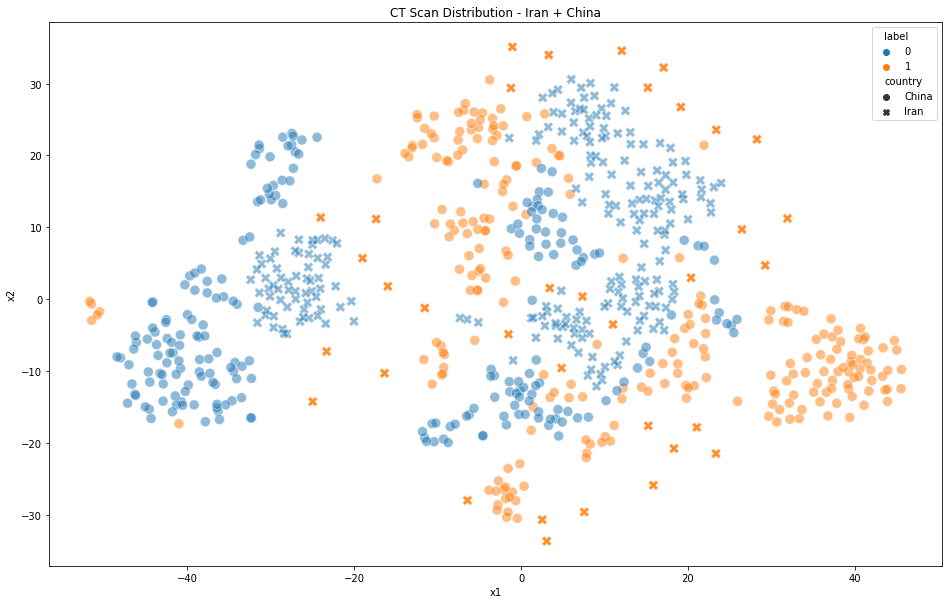

In [ ]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


# CT Scan Distribution - Iran + China

ct = china_ct+iran_ct
ct = pd.DataFrame(data=ct)
country = ["China"]*458 + ["Iran"]*335
label = np.concatenate((China_label, Iran_label), axis=0)
pca = PCA(n_components=0.95)
ct_pca = pca.fit_transform(ct)
ct_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(ct_pca)
ct_tsne = pd.DataFrame(ct_tsne, columns=["x1", "x2"])

ct_tsne["country"] = country
ct_tsne["label"] = label

plt.figure(figsize=(16,10))
sns.scatterplot(
        x="x1", y="x2",
        hue="label",
        style="country",
        data=ct_tsne,
        s = 100,
        alpha=0.5
    )
plt.title("CT Scan Distribution - Iran + China")

## CT Scan Clustering for Each Label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


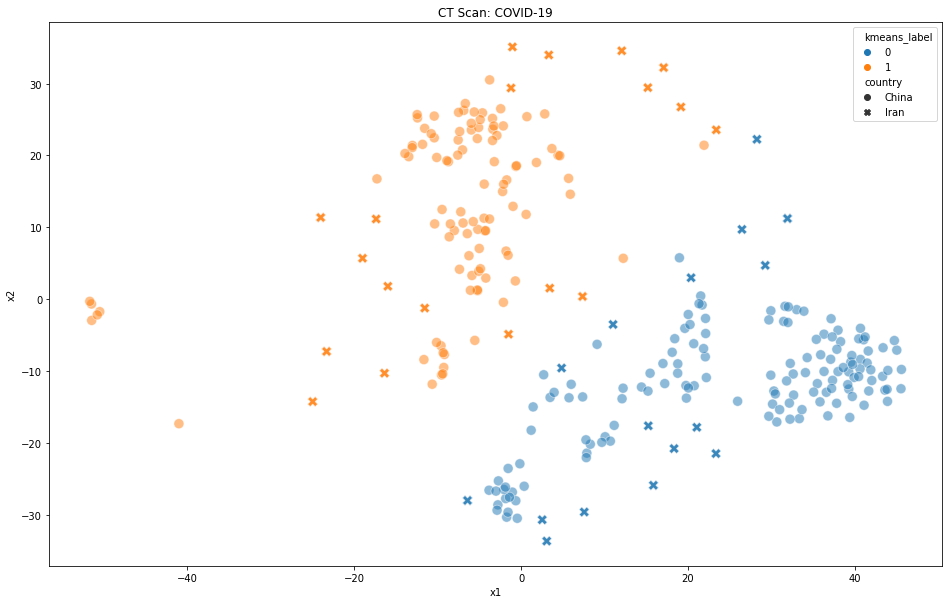

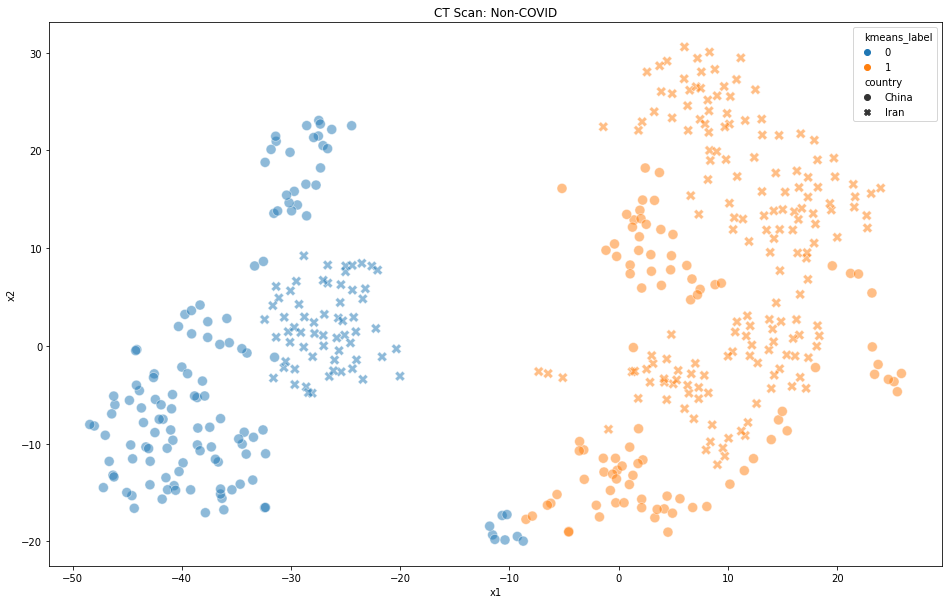

In [ ]:
# CT Scan Clustering: COVID and NON-COVID - Iran + China
df = ct_tsne
covid = df[df["label"]==1]
noncovid = df[df["label"]==0]

kmeans_covid = KMeans(n_clusters=2, random_state=42).fit(covid[["x1", "x2"]])
kmeans_noncovid = KMeans(n_clusters=2, random_state=42).fit(noncovid[["x1", "x2"]])
covid["kmeans_label"] = kmeans_covid.labels_
noncovid["kmeans_label"] = kmeans_noncovid.labels_

datasets = [covid, noncovid]
title = ["COVID-19", "Non-COVID"]

for i in range(0, 2):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="x1", y="x2",
        hue="kmeans_label",
        style="country",
        data=datasets[i],
        s = 100,
        alpha=0.5
    )
    plt.title("CT Scan: " + title[i])

## CXR Distribution

Text(0.5, 1.0, 'CXR Distribution - Iran + China')

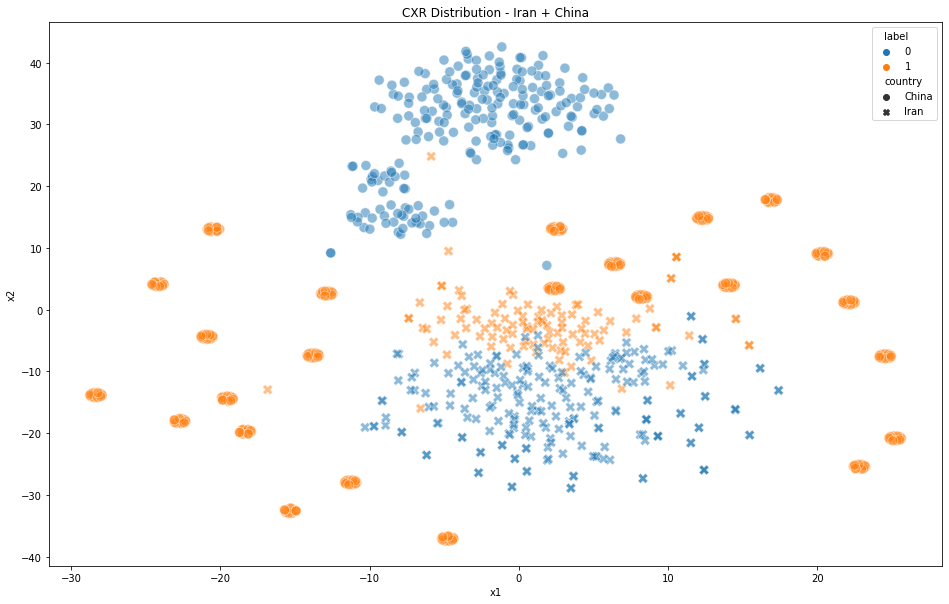

In [ ]:
# CXR Distribution - Iran + China
cxr = china_cxr+iran_cxr
cxr = pd.DataFrame(data=cxr)
pca = PCA(n_components=0.95)
cxr_pca = pca.fit_transform(cxr)
cxr_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(cxr_pca)

cxr_tsne = pd.DataFrame(cxr_tsne, columns=["x1", "x2"])

cxr_tsne["country"] = country
cxr_tsne["label"] = label

plt.figure(figsize=(16,10))
sns.scatterplot(
        x="x1", y="x2",
        hue="label",
        style="country",
        data=cxr_tsne,
        s = 100,
        alpha=0.5
    )
plt.title("CXR Distribution - Iran + China")


## CXR Clustering for Each Label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


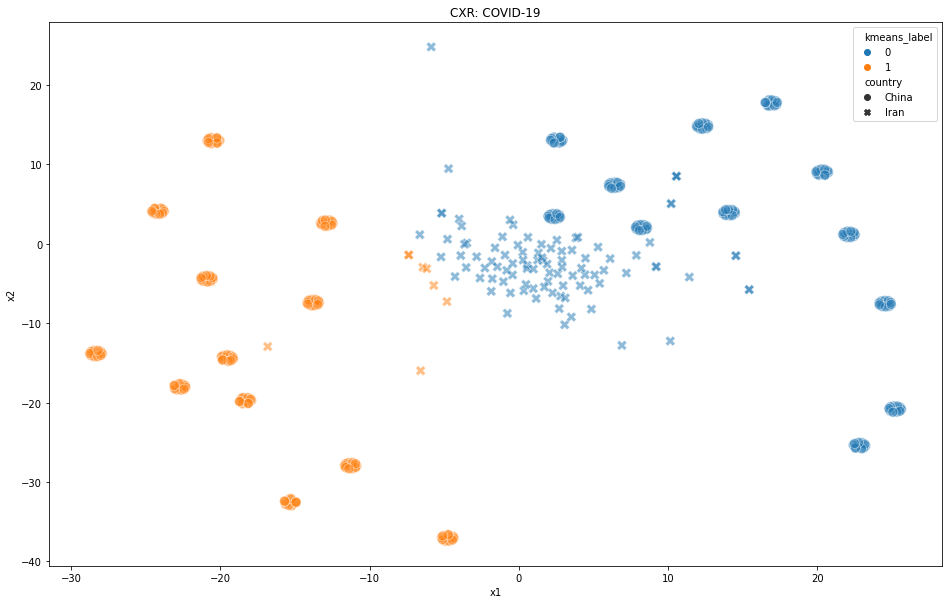

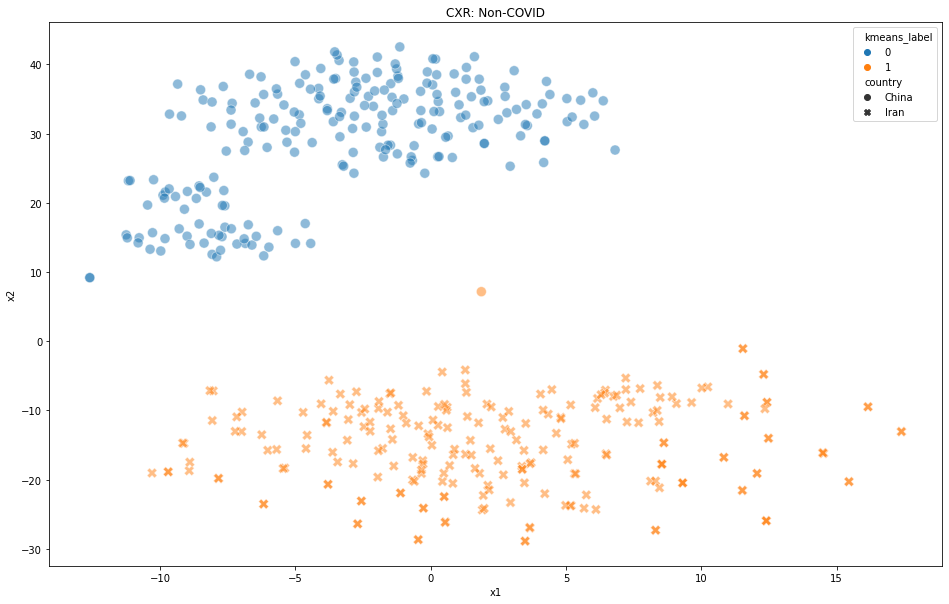

In [ ]:
# CXR Clustering: COVID and NON-COVID - Iran + China

df = cxr_tsne
covid = df[df["label"]==1]
noncovid = df[df["label"]==0]

kmeans_covid = KMeans(n_clusters=2, random_state=42).fit(covid[["x1", "x2"]])
kmeans_noncovid = KMeans(n_clusters=2, random_state=42).fit(noncovid[["x1", "x2"]])
covid["kmeans_label"] = kmeans_covid.labels_
noncovid["kmeans_label"] = kmeans_noncovid.labels_

datasets = [covid, noncovid]
title = ["COVID-19", "Non-COVID"]

for i in range(0, 2):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="x1", y="x2",
        hue="kmeans_label",
        style="country",
        data=datasets[i],
        s = 100,
        alpha=0.5
    )
    plt.title("CXR: " + title[i])

## Fused Features Distribution (CT+CXR)

Text(0.5, 1.0, 'Fused Features Distribution - Iran + China')

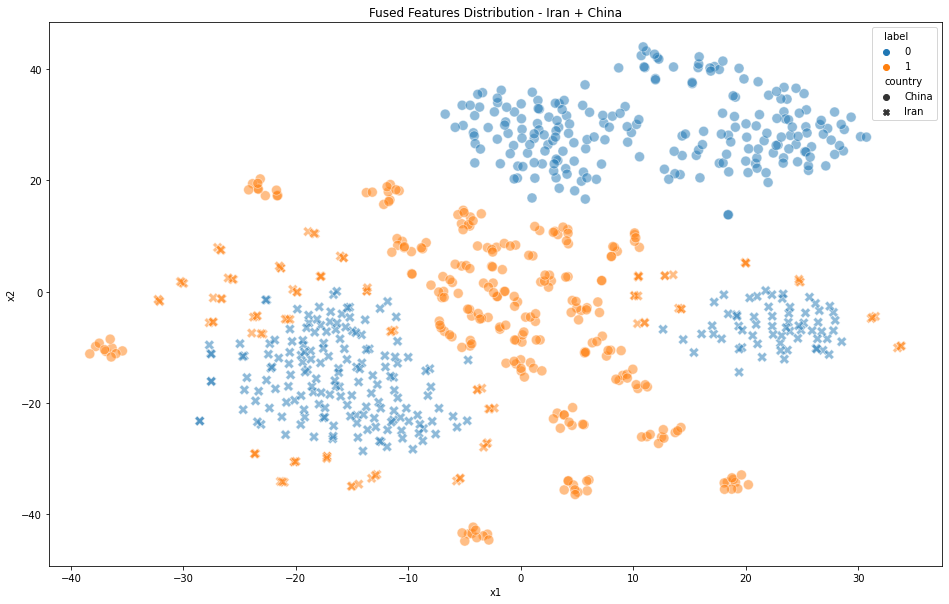

In [ ]:
# fused feature distribution - Iran & China

fused = china_fused + iran_fused
fused = pd.DataFrame(data=fused)
pca = PCA(n_components=0.95)
fused_pca = pca.fit_transform(fused)
fused_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(fused_pca)

fused_tsne = pd.DataFrame(fused_tsne, columns=["x1", "x2"])
fused_tsne["country"] = country
fused_tsne["label"] = label

plt.figure(figsize=(16,10))
sns.scatterplot(
        x="x1", y="x2",
        hue="label",
        style="country",
        data=fused_tsne,
        s = 100,
        alpha=0.5
    )
plt.title("Fused Features Distribution - Iran + China")


## Fused Features Clustering for Each Label (CT+CXR)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


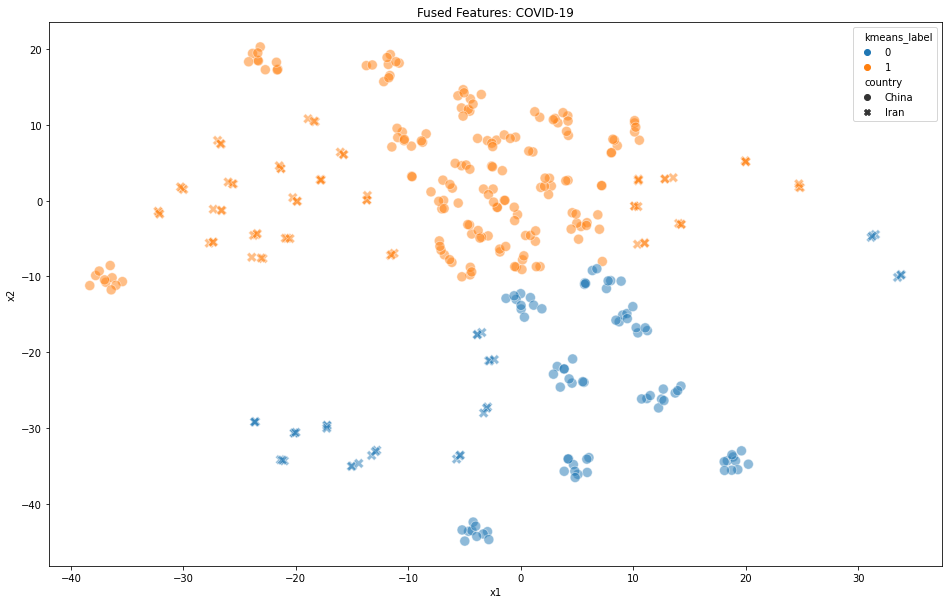

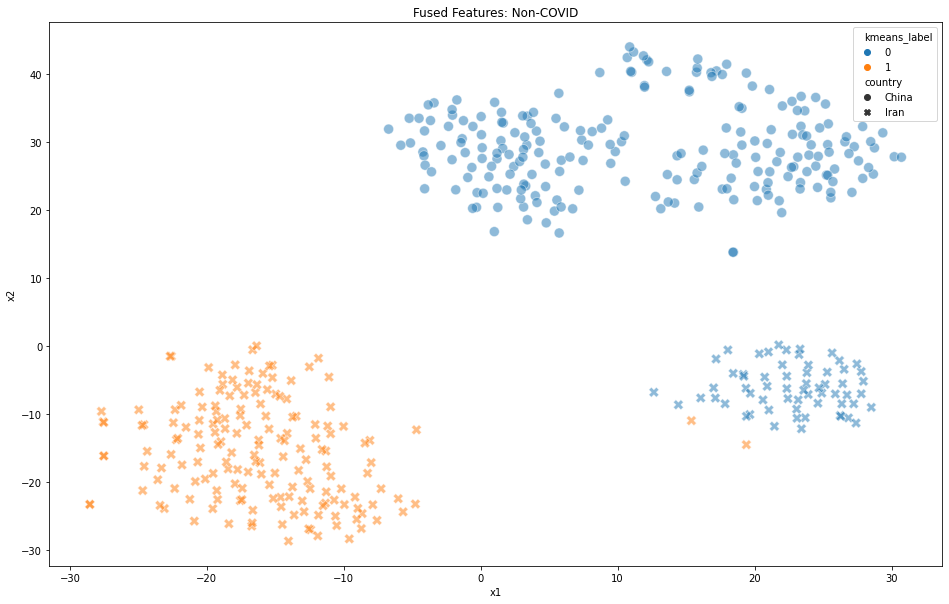

In [ ]:
# fused feature clustering: COVID and NON-COVID - Iran + China
df = fused_tsne
covid = df[df["label"]==1]
noncovid = df[df["label"]==0]
kmeans_covid = KMeans(n_clusters=2, random_state=42).fit(covid[["x1", "x2"]])
kmeans_noncovid = KMeans(n_clusters=2, random_state=42).fit(noncovid[["x1", "x2"]])
covid["kmeans_label"] = kmeans_covid.labels_
noncovid["kmeans_label"] = kmeans_noncovid.labels_

datasets = [covid, noncovid]
title = ["COVID-19", "Non-COVID"]

for i in range(0, 2):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="x1", y="x2",
        hue="kmeans_label",
        style="country",
        data=datasets[i],
        s = 100,
        alpha=0.5
    )
    plt.title("Fused Features: " + title[i])